In [1]:
# Import Dependencies
%matplotlib notebook
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Read SQLite file into python through SQLalchemy
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

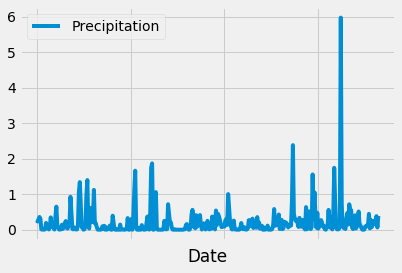

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

    
# Calculate the date 1 year ago from today
base_date = dt.datetime.strptime("2017-06-14", "%Y-%m-%d")
numdays = 365
date_list = [base_date - dt.timedelta(days=x) for x in range(0, numdays)]

# Perform a query to retrieve the data and precipitation scores
str_dates = []
for date in date_list:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)
    
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
               .filter(Measurement.date.in_(str_dates))\
               .group_by(Measurement.date)

prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])
    
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)

# Sort the dataframe by date
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.savefig("Images/precipitation_analysis.png")
plt.show()
# Rotate the xticks for the dates

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df["Precipitation"].describe()

count     365.0
unique    242.0
top         0.0
freq       46.0
Name: Precipitation, dtype: float64

In [10]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [11]:
# What are the most active stations?
# List the stations and the counts in descending order.
obs_counts = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())

for station in obs_counts:
    print(station)

top_station = obs_counts[0][0]

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

        

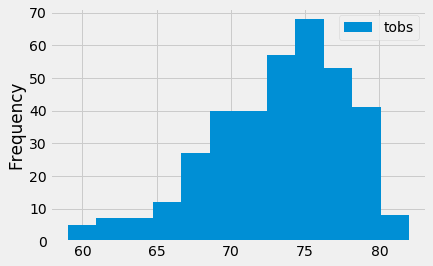

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_results = session.query(Measurement.tobs)\
               .filter(Measurement.date.in_(str_dates))\
               .filter(Measurement.station == top_station)

tobs_data = []
for row in tobs_results:
    tobs_data.append(row[0])
    
plt.hist(tobs_data, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/station_analysis.png")
plt.show()

In [14]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    
#     return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# print(calc_temps('2012-02-28', '2012-03-05'))

def calc_temps (start_date, end_date):
    
    # Converting to date time
    startDate = dt.datetime.strptime(start_date, "%Y-%m-%d")
    startDate = startDate.replace(startDate.year - 1)
    endDate = dt.datetime.strptime(end_date, "%Y-%m-%d")
    endDate = endDate.replace(endDate.year - 1)
   
    
    # Getting date range
    delta = endDate - startDate
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(startDate + timedelta(days=i))
        
    # Converting to strings to filter
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
        
    # Grabbing avg, min & max temps    
    temp_avg = session.query(func.avg(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
        
    return temp_avg, temp_min, temp_max

In [15]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_analysis = calc_temps("2016-06-14", "2016-06-17")

# Creating variables
tavg = temp_analysis[0]
tmin = temp_analysis[1]
tmax = temp_analysis[2]

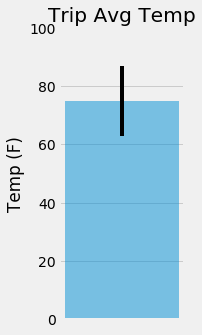

In [16]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_analysis.png")
plt.show()

In [17]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [18]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [21]:
# Plot the daily normals as an area plot with `stacked=False`
